In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
def load_and_preprocess_data(base_path, sequence_length=50):
    
    datasets = []
    labels = []
    
    label_map = {'pull_shot': 0, 'cover_drive': 1, 'wrong_shot': 2}
    
    for shot_type in label_map.keys():
        folder_path = os.path.join(base_path, shot_type)
        # print(folder_path)
        
        for file in os.listdir(folder_path):
            if file.endswith('.xlsx'):
                file_path = os.path.join(folder_path, file)
                df = pd.read_excel(file_path)
                
                # Extract features
                shoulder_angles = df['LShoulder_Avg'].values
                elbow_angles = df['LElbow_Avg'].values
                
                # Add data augmentation
                # 1. Add noise
                shoulder_noisy = shoulder_angles + np.random.normal(0, 0.5, shoulder_angles.shape)
                elbow_noisy = elbow_angles + np.random.normal(0, 0.5, elbow_angles.shape)
                
                # 2. Time shifting
                shift = np.random.randint(-5, 6)
                shoulder_shifted = np.roll(shoulder_angles, shift)
                elbow_shifted = np.roll(elbow_angles, shift)
                
                # Process original data
                for i in range(0, len(df) - sequence_length + 1, sequence_length // 4):
                    # Create base sequence
                    sequence = np.column_stack((
                        shoulder_angles[i:i+sequence_length],
                        elbow_angles[i:i+sequence_length]
                    ))
                    
                    # Calculate derivatives
                    velocity = np.gradient(sequence, axis=0)
                    acceleration = np.gradient(velocity, axis=0)
                    
                    # Combine all features into a single array with shape (sequence_length, 6)
                    full_sequence = np.concatenate([sequence, velocity, acceleration], axis=1)
                    datasets.append(full_sequence)
                    labels.append(label_map[shot_type])
                
                # Process augmented data
                for data_pair in [(shoulder_noisy, elbow_noisy), (shoulder_shifted, elbow_shifted)]:
                    for i in range(0, len(df) - sequence_length + 1, sequence_length // 2):
                        sequence = np.column_stack((
                            data_pair[0][i:i+sequence_length],
                            data_pair[1][i:i+sequence_length]
                        ))
                        
                        velocity = np.gradient(sequence, axis=0)
                        acceleration = np.gradient(velocity, axis=0)
                        
                        full_sequence = np.concatenate([sequence, velocity, acceleration], axis=1)
                        datasets.append(full_sequence)
                        labels.append(label_map[shot_type])
    
    return np.array(datasets), np.array(labels)

In [119]:
def create_enhanced_model(sequence_length, n_features=6):
    
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # CNN layers with residual connections
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    residual = x
    
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.MaxPooling1D(2)(x)
    
    # Self-attention mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    
    # Dense layers with skip connections
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [120]:
def plot_training_metrics(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [121]:
def plot_confusion_matrix(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [122]:
def evaluate_model(model, X_val, y_val):

    # Get predictions
    y_pred = np.argmax(model.predict(X_val), axis=1)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, 
                              target_names=['Pull Shot', 'Cover Drive', 'Wrong Shot'],
                              digits=4))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_val, y_pred)

In [123]:
def train_with_cross_validation(base_path, n_folds=5, epochs=100, batch_size=32, sequence_length=50):

    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data(base_path, sequence_length)
    print(f"Data shape: {X.shape}")
    
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    best_accuracy = 0
    best_history = None
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f'\nFold {fold + 1}/{n_folds}')
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Scale the features
        scaler = StandardScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
        
        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_val_scaled = scaler.transform(X_val_reshaped)
        
        X_train_scaled = X_train_scaled.reshape(X_train.shape)
        X_val_scaled = X_val_scaled.reshape(X_val.shape)
        
        # Create and compile model
        model = create_enhanced_model(sequence_length)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        early_stopping = callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.00001
        )
        
        # Train model
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Evaluate model
        _, accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
        fold_accuracies.append(accuracy)
        
        # Save best model and history
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_scaler = scaler
            best_history = history
            best_X_val = X_val_scaled
            best_y_val = y_val
    
    print("\nCross-validation results:")
    print(f"Mean accuracy: {np.mean(fold_accuracies):.4f}")
    print(f"Std accuracy: {np.std(fold_accuracies):.4f}")
    
    return best_model, best_scaler, best_history, best_X_val, best_y_val

In [124]:
def plot_data_comparison(base_path, sequence_length=20):

    # Load a single example file for demonstration
    shot_types = ['pull_shot', 'cover_drive', 'wrong_shot']
    
    plt.figure(figsize=(15, 12))
    
    for idx, shot_type in enumerate(shot_types):
        folder_path = os.path.join(base_path, shot_type)
        print(folder_path)
        files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
        print(f"Processing shot type: {shot_type}")
        print(f"Folder path: {folder_path}")
        print(f"Files found: {files}")
        if files:
            # print("Ishan")
            # Load first file of each type
            df = pd.read_excel(os.path.join(folder_path, files[0]))
            
            print(f"Loading file: {files[0]}")
            print(f"Columns in the file: {df.columns.tolist()}")
            
            # Original data
            shoulder_orig = df['LShoulder_Avg'].values[:sequence_length]
            elbow_orig = df['LElbow_Avg'].values[:sequence_length]
            
            # Generate augmented versions
            # Noisy version
            shoulder_noisy = shoulder_orig + np.random.normal(0, 0.5, shoulder_orig.shape)
            elbow_noisy = elbow_orig + np.random.normal(0, 0.5, elbow_orig.shape)
            
            # Shifted version
            shift = 5
            shoulder_shifted = np.roll(shoulder_orig, shift)
            elbow_shifted = np.roll(elbow_orig, shift)
            
            # Plot comparisons
            plt.subplot(3, 2, 2*idx + 1)
            plt.title(f'{shot_type} - Shoulder Angle Comparison')
            plt.plot(shoulder_orig, label='Original', linewidth=2)
            plt.plot(shoulder_noisy, label='Noisy', alpha=0.7)
            plt.plot(shoulder_shifted, label='Shifted', alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Angle')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(3, 2, 2*idx + 2)
            plt.title(f'{shot_type} - Elbow Angle Comparison')
            plt.plot(elbow_orig, label='Original', linewidth=2)
            plt.plot(elbow_noisy, label='Noisy', alpha=0.7)
            plt.plot(elbow_shifted, label='Shifted', alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Angle')
            plt.legend()
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()


Generating data augmentation comparison plot...
./base\pull_shot
Processing shot type: pull_shot
Folder path: ./base\pull_shot
Files found: ['time_and_average_10.xlsx', 'time_and_average_100.xlsx', 'time_and_average_101.xlsx', 'time_and_average_102.xlsx', 'time_and_average_103.xlsx', 'time_and_average_104.xlsx', 'time_and_average_105.xlsx', 'time_and_average_106.xlsx', 'time_and_average_107.xlsx', 'time_and_average_108.xlsx', 'time_and_average_109.xlsx', 'time_and_average_11.xlsx', 'time_and_average_111.xlsx', 'time_and_average_112.xlsx', 'time_and_average_113.xlsx', 'time_and_average_114.xlsx', 'time_and_average_115.xlsx', 'time_and_average_116.xlsx', 'time_and_average_117.xlsx', 'time_and_average_118.xlsx', 'time_and_average_119.xlsx', 'time_and_average_12.xlsx', 'time_and_average_120.xlsx', 'time_and_average_121.xlsx', 'time_and_average_122.xlsx', 'time_and_average_123.xlsx', 'time_and_average_124.xlsx', 'time_and_average_125.xlsx', 'time_and_average_126.xlsx', 'time_and_average_127

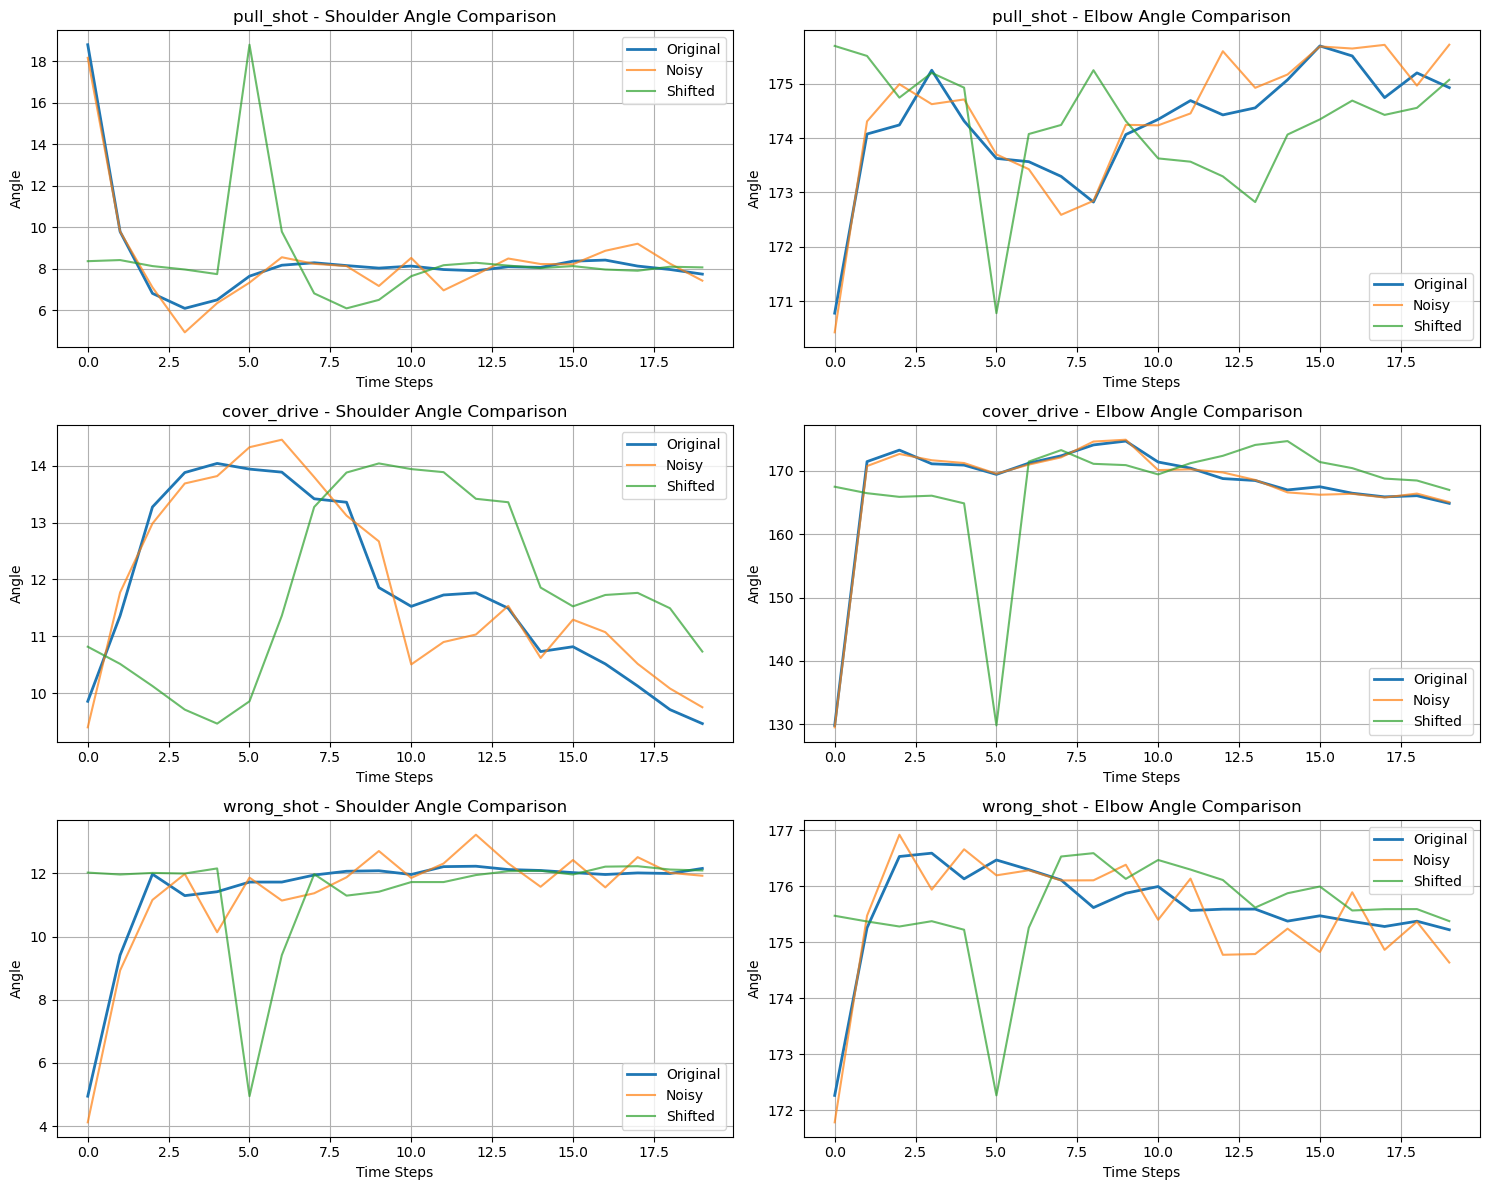

Loading and preprocessing data...
Data shape: (4475, 50, 6)

Fold 1/5
Epoch 1/100
112/112 [==============================] - 24s 150ms/step - loss: 0.8389 - accuracy: 0.6137 - val_loss: 0.7399 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 16s 145ms/step - loss: 0.6683 - accuracy: 0.7207 - val_loss: 0.6676 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 16s 143ms/step - loss: 0.6076 - accuracy: 0.7472 - val_loss: 0.5824 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 16s 143ms/step - loss: 0.5582 - accuracy: 0.7774 - val_loss: 0.6015 - val_accuracy: 0.7497 - lr: 0.0010
Epoch 5/100
112/112 [==============================] - 17s 149ms/step - loss: 0.5000 - accuracy: 0.8084 - val_loss: 0.4795 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 6/100
112/112 [==============================] - 17s 150ms/step - loss: 0.4551 - accuracy: 0.8293 - val_loss: 0.4909 - val_accura

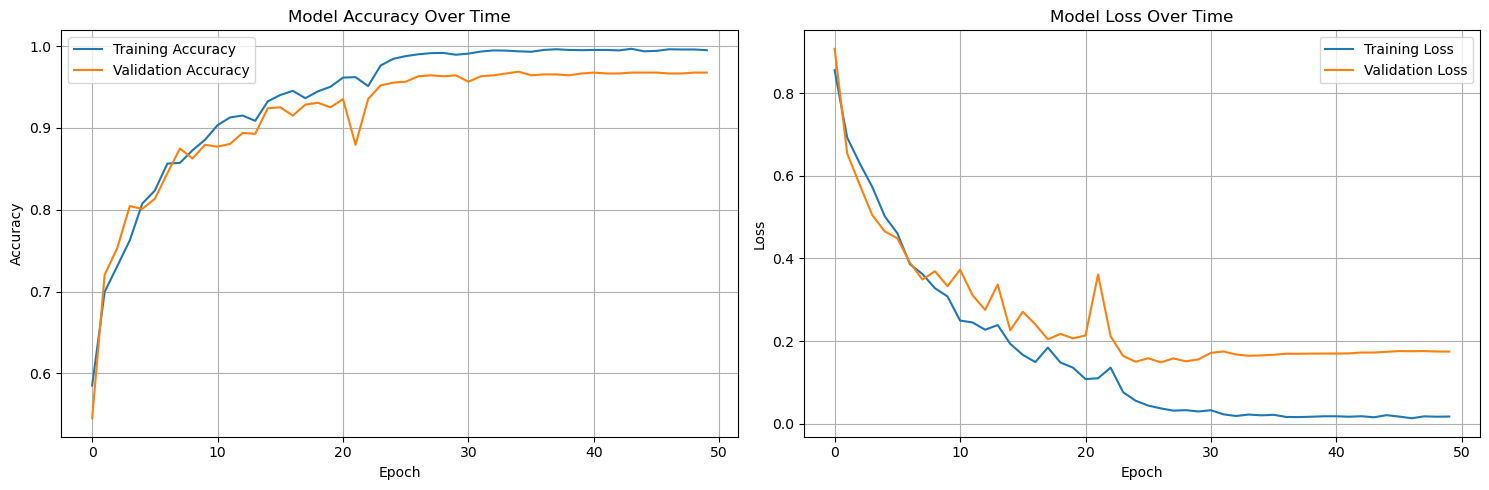


Classification Report:
              precision    recall  f1-score   support

   Pull Shot     0.9656    0.9776    0.9716       402
 Cover Drive     0.9756    0.9622    0.9689       291
  Wrong Shot     0.9652    0.9604    0.9628       202

    accuracy                         0.9687       895
   macro avg     0.9688    0.9667    0.9677       895
weighted avg     0.9688    0.9687    0.9687       895



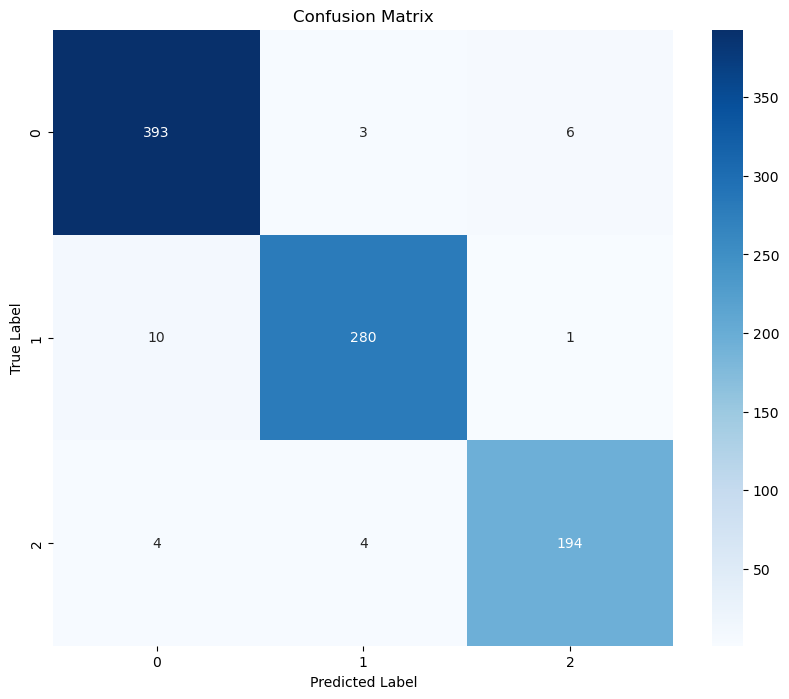

In [125]:
if __name__ == "__main__":
    BASE_PATH = "./base"

    # Plot data comparison
    print("Generating data augmentation comparison plot...")
    plot_data_comparison(BASE_PATH)
    
    # Train the model and get evaluation metrics
    best_model, best_scaler, history, X_val, y_val = train_with_cross_validation(BASE_PATH)
    
    # Plot training metrics
    plot_training_metrics(history)
    
    # Evaluate and visualize results
    evaluate_model(best_model, X_val, y_val)
    
    # Save the model and scaler
    best_model.save('cricket_shot_classifier.h5')
    import joblib
    joblib.dump(best_scaler, 'scaler.pkl')